<a href="https://colab.research.google.com/github/Alextsaiwdf/htmlpractice.github.io/blob/main/Skin_Cancer_Detection_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'isic-2024-challenge:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F63056%2F9094797%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241007%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241007T031118Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D35161bd1437d6e495b7037d2e59ceb13f24f98a9eb109cc19dad0e3d94b60530776f63599a60271604fdf8e871309b0fd32f010d06acb21e63885a36b2c542c12b80a20ddc521f5b771c06f5e22901a248c45af83ddf6ea92d91689f2efa13654e4abce42acc50c25c726a7eeda87dae4838999186e6c5137aaf4dcc2af6073fb4b47284cf4469461784ccbebd0c730bcdf114909a62586bbd03c113a764ff4c8f0a5531ea0e27d9bd31a4dc5da8f287b67e7b102223bfbcf2b9a31166029913fdbc6e55bce9c4c0b383eed38610304310f96a42155a4b1b9505924be68ef9139ee2683ebd36df03a52be20eaaaa0a096c2fdb5987856edefcc10f540a47596d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2148525604 bytes downloaded
Downloaded and uncompressed: isic-2024-challenge
Data source import complete.


## Importing Necessary Libraries

In [2]:
import os
import json
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from IPython.display import display
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import h5py

# Ensure TensorFlow is initialized only once
import tensorflow as tf
if not tf.executing_eagerly():
    tf.compat.v1.enable_eager_execution()

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, save_img

In [3]:
root_dir = '/kaggle/input'

for item in os.listdir(root_dir):
    item_path = os.path.join(root_dir, item)
    if os.path.isdir(item_path):
        print(f"Folder: {item}")
        for filename in os.listdir(item_path):
            file_path = os.path.join(item_path, filename)
            if os.path.isfile(file_path):
                print(file_path)
    elif os.path.isfile(item_path):
        print(item_path)

!ls /kaggle/input/isic-2024-challenge

Folder: isic-2024-challenge
/kaggle/input/isic-2024-challenge/train-metadata.csv
/kaggle/input/isic-2024-challenge/test-image.hdf5
/kaggle/input/isic-2024-challenge/train-image.hdf5
/kaggle/input/isic-2024-challenge/sample_submission.csv
/kaggle/input/isic-2024-challenge/test-metadata.csv
sample_submission.csv  test-metadata.csv  train-image.hdf5
test-image.hdf5        train-image	  train-metadata.csv


## Basic Data Exploration

In [4]:
df = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv', low_memory=False)
df

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,IL_9520694,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,IL_9852274,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000


#### Data Imbalancement

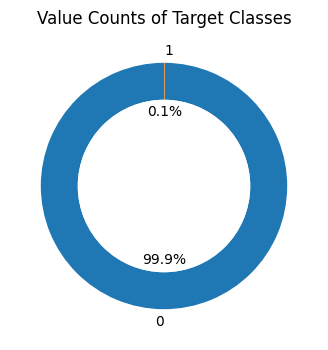

In [5]:
dist = df.target.value_counts()

plt.figure(figsize=(4, 4))
plt.pie(dist.values, labels=dist.index.astype(str), autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3))

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Value Counts of Target Classes')
plt.show()

In [6]:
df.drop_duplicates(inplace=True)
df

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,IL_9520694,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,IL_9852274,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000


In [7]:
df_test = pd.read_csv('/kaggle/input/isic-2024-challenge/test-metadata.csv', low_memory=False)
df_test

,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


In [8]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
isic_id,401059,401059,ISIC_0015670,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
target,401059.0,NaN,NaN,NaN,0.00098,0.031288,0.0,0.0,0.0,0.0,1.0
patient_id,401059,1042,IP_1117889,9184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age_approx,398261.0,NaN,NaN,NaN,58.012986,13.596165,5.0,50.0,60.0,70.0,85.0
sex,389542,2,male,265546,NaN,NaN,NaN,NaN,NaN,NaN,NaN
anatom_site_general,395303,5,posterior torso,121902,NaN,NaN,NaN,NaN,NaN,NaN,NaN
clin_size_long_diam_mm,401059.0,NaN,NaN,NaN,3.930827,1.743068,1.0,2.84,3.37,4.38,28.4
image_type,401059,1,TBP tile: close-up,401059,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tbp_tile_type,401059,2,3D: XP,285903,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tbp_lv_A,401059.0,NaN,NaN,NaN,19.974007,3.999489,-2.487115,17.330821,19.80191,22.304628,48.18961


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    398261 non-null  float64
 4   sex                           389542 non-null  object 
 5   anatom_site_general           395303 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A                      401059 non-null  float64
 10  tbp_lv_Aext                   401059 non-null  float64
 11  tbp_lv_B                      401059 non-null  float64
 12  tbp_lv_Bext                   401059 non-nul

## Data Transformation using Encoding and Normalization

In [10]:
df['tbp_lv_location_simple'] = df['tbp_lv_location_simple'].replace('Unknown', np.nan)

In [11]:
columns_to_drop = [
    'patient_id', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
    'mel_mitotic_index', 'mel_thick_mm', 'tbp_tile_type','lesion_id', 'iddx_full',
    'iddx_1', 'attribution', 'copyright_license', 'image_type','tbp_lv_dnn_lesion_confidence','isic_id','target'
]


num_cols = [
    'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext',
    'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H',
    'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2',
    'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA',
    'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
    'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence',
    'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
    'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
    'tbp_lv_symm_2axis', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z'
]

cat_cols = [
    'sex', 'anatom_site_general',
    'tbp_lv_location', 'tbp_lv_location_simple',
    'tbp_lv_symm_2axis_angle'
]

In [12]:
# Custom transformer to drop columns if they are present
class DropIfPresent(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        columns_to_drop = [col for col in self.columns_to_drop if col in X.columns]
        return X.drop(columns=columns_to_drop, errors='ignore')



# Define the pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Handle unknown categories
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols),
], remainder='passthrough')  # Handle columns not specified in the transformers

pipeline = Pipeline([
    ('drop_columns', DropIfPresent(columns_to_drop=columns_to_drop)),
    ('preprocessor', preprocessor)
])

In [13]:
# Function to preprocess training data
def preprocess_train_data(df, pipeline):
    df_dropped = pipeline.named_steps['drop_columns'].transform(df)
    df_processed = pipeline.named_steps['preprocessor'].fit_transform(df_dropped)
    num_features = [col for col in num_cols if col in df_dropped.columns]
    cat_features = pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(cat_cols)
    all_features = np.concatenate([num_features, cat_features])
    df_processed = pd.DataFrame(df_processed, columns=all_features)
    return df_processed

In [14]:
# Function to preprocess test data
def preprocess_test_data(df_test, pipeline):
    df_test_dropped = pipeline.named_steps['drop_columns'].transform(df_test)
    df_test_processed = pipeline.named_steps['preprocessor'].transform(df_test_dropped)
    num_features = [col for col in num_cols if col in df_test_dropped.columns]
    cat_features = pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(cat_cols)
    all_features = np.concatenate([num_features, cat_features])
    df_test_processed = pd.DataFrame(df_test_processed, columns=all_features)
    return df_test_processed

In [15]:
target = list(df.target)
isic_id = list(df['isic_id'])

df_train_processed = preprocess_train_data(df, pipeline)
df_train_processed['target'] = target
df_train_processed['isic_id'] = isic_id

print("Processed Training Data:")
df_train_processed


Processed Training Data:


,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,...,tbp_lv_symm_2axis_angle_140,tbp_lv_symm_2axis_angle_145,tbp_lv_symm_2axis_angle_150,tbp_lv_symm_2axis_angle_155,tbp_lv_symm_2axis_angle_160,tbp_lv_symm_2axis_angle_165,tbp_lv_symm_2axis_angle_170,tbp_lv_symm_2axis_angle_175,target,isic_id
0,0.146658,-0.511069,0.067613,0.380443,-0.257500,-0.659882,-0.192995,-0.407543,-0.288931,-0.917620,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,ISIC_0015670
1,0.146658,-1.624050,2.935019,2.959583,-0.369545,-0.527265,1.126869,0.906538,-2.708061,-3.006591,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,ISIC_0015845
2,0.146658,-0.304536,0.650540,0.625867,1.835454,1.466075,1.644677,1.385391,0.835409,0.339647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,ISIC_0015864
3,0.515699,-0.407803,-1.433104,-0.780446,-1.294561,-1.291919,-1.583639,-1.355725,0.318926,-0.166282,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,ISIC_0015902
4,-0.222383,-0.688917,1.188031,1.455843,-0.344179,-0.268249,0.250792,0.349419,-1.396095,-1.590171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,ISIC_0024200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,0.884739,1.646049,0.650166,0.007202,-0.117160,-0.032541,0.160952,-0.054822,-0.700893,-0.030617,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,ISIC_9999937
401055,0.146658,-0.470910,0.000908,0.313829,1.113374,0.914313,0.838322,0.825604,0.910238,0.297111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,ISIC_9999951
401056,0.515699,-1.079034,-0.660445,-0.723881,0.296215,-0.092113,-0.047848,-0.347591,0.941991,0.708522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,ISIC_9999960
401057,-2.067587,-0.648757,0.578715,-1.517130,0.028320,0.022136,0.234743,-0.469141,-0.497799,1.687649,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,ISIC_9999964


In [16]:
for i in df_train_processed.columns:
    print(i,'     ',df_train_processed[i].dtypes)

age_approx       float64
clin_size_long_diam_mm       float64
tbp_lv_A       float64
tbp_lv_Aext       float64
tbp_lv_B       float64
tbp_lv_Bext       float64
tbp_lv_C       float64
tbp_lv_Cext       float64
tbp_lv_H       float64
tbp_lv_Hext       float64
tbp_lv_L       float64
tbp_lv_Lext       float64
tbp_lv_areaMM2       float64
tbp_lv_area_perim_ratio       float64
tbp_lv_color_std_mean       float64
tbp_lv_deltaA       float64
tbp_lv_deltaB       float64
tbp_lv_deltaL       float64
tbp_lv_deltaLB       float64
tbp_lv_deltaLBnorm       float64
tbp_lv_eccentricity       float64
tbp_lv_minorAxisMM       float64
tbp_lv_nevi_confidence       float64
tbp_lv_norm_border       float64
tbp_lv_norm_color       float64
tbp_lv_perimeterMM       float64
tbp_lv_radial_color_std_max       float64
tbp_lv_stdL       float64
tbp_lv_stdLExt       float64
tbp_lv_symm_2axis       float64
tbp_lv_x       float64
tbp_lv_y       float64
tbp_lv_z       float64
sex_female       float64
sex_male       floa

In [17]:
for i in df_test.columns:
    print(df_test[i].unique())

['ISIC_0015657' 'ISIC_0015729' 'ISIC_0015740']
['IP_6074337' 'IP_1664139' 'IP_7142616']
[45. 35. 65.]
['male' 'female']
['posterior torso' 'lower extremity']
[2.7  2.52 3.16]
['TBP tile: close-up']
['3D: XP']
[22.80433   16.6486699 24.25384  ]
[20.00727    9.6579644 19.93738  ]
[28.38412    31.31752006 30.46368   ]
[27.04364    27.52431819 28.38424   ]
[36.4101     35.46780613 38.9395    ]
[33.64      29.1695795 34.68666  ]
[51.22096    62.00449424 51.47473   ]
[53.50543    70.66461893 54.91541   ]
[24.97985 59.90409 35.81945]
[31.1146     68.14107118 41.35864   ]
[3.846876   2.12047288 3.39651   ]
[22.90701    18.95782093 19.4644    ]
[0.4611487 0.        0.2512358]
[2.797056  6.9907055 4.316465 ]
[1.340481   3.79320187 2.079433  ]
[-6.134747   -8.23698117 -5.539191  ]
[6.436557   9.15112691 6.041092  ]
[6.843057   6.08338803 5.446997  ]
[0.6644654  0.92669839 0.8947765 ]
['Torso Back Top Third' 'Left Leg - Upper']
['Torso Back' 'Left Leg']
[2.187644   1.03266605 1.520786  ]
[1.698104

In [18]:
isic_id_test = list(df_test['isic_id'])

df_test_processed = preprocess_test_data(df_test, pipeline)
df_test_processed['isic_id'] = isic_id_test

print("Processed Test Data:")
df_test_processed

Processed Test Data:


,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,...,tbp_lv_symm_2axis_angle_135,tbp_lv_symm_2axis_angle_140,tbp_lv_symm_2axis_angle_145,tbp_lv_symm_2axis_angle_150,tbp_lv_symm_2axis_angle_155,tbp_lv_symm_2axis_angle_160,tbp_lv_symm_2axis_angle_165,tbp_lv_symm_2axis_angle_170,tbp_lv_symm_2axis_angle_175,isic_id
0,-0.960465,-0.706128,0.707672,1.441620,0.019401,0.029138,0.284448,0.562959,-0.621776,-1.330179,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_0015657
1,-1.698546,-0.809394,-0.831441,-1.490710,0.575110,0.136361,0.119378,-0.362720,1.331464,1.716605,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_0015729
2,0.515699,-0.442225,1.070096,1.421817,0.413357,0.328180,0.727544,0.779689,-0.575811,-1.079823,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_0015740



## Augementing Data using Synthetic Minority Over-sampling Technique


In [19]:
# df_train_processed.head()
df_train_processed['target'].value_counts()

,count
target,
0,400666
1,393


In [20]:
# sampled_df_list = [
#     group.sample(min(len(group), 500 if name == 1 else 35000))
#     for name, group in df_train_processed.groupby('target')
# ]
# df_train_processed = pd.concat(sampled_df_list).reset_index(drop=True)



# df_train_processed

In [21]:
# # Directory containing the images
# dir_path = '/kaggle/input/isic-2024-challenge/train-image/image'

# # Load ISIC_ids from your DataFrame
# isic_ids = df_train_processed['isic_id'].values

# # Generate file paths based on ISIC_ids
# image_paths = [os.path.join(dir_path, f"{isic_id}.jpg") for isic_id in isic_ids]

# # Check if image paths exist
# valid_image_paths = [path for path in image_paths if os.path.exists(path)]
# print("total isic   ",len(valid_image_paths))

In [22]:
# target_size = (128, 128)  # target size for padding

# # Function to resize and pad an image to the target size using nearest pixel values
# def resize_and_pad_image(image, target_size):
#     h, w = image.shape[:2]
#     # Calculate the resize ratio to maintain aspect ratio
#     ratio = min(target_size[0] / h, target_size[1] / w)
#     new_size = (int(w * ratio), int(h * ratio))

#     # Resize the image
#     resized_image = cv2.resize(image, new_size, interpolation=cv2.INTER_AREA)

#     # Calculate padding to reach the target size
#     pad_h = target_size[0] - resized_image.shape[0]
#     pad_w = target_size[1] - resized_image.shape[1]
#     top, bottom = pad_h // 2, pad_h - (pad_h // 2)
#     left, right = pad_w // 2, pad_w - (pad_w // 2)

#     # Pad image with nearest pixel values
#     padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_REPLICATE)
#     return padded_image

# # Load, resize, pad, and display the first five valid images
# for image_path in valid_image_paths[:5]:
#     # Load image
#     image = cv2.imread(image_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

#     # Print original shape
#     original_shape = image.shape
#     print(f"Original shape of {os.path.basename(image_path)}: {original_shape} - {'3D (RGB)' if len(original_shape) == 3 else '2D (Grayscale)'}")

#     # Resize and pad image
#     resized_and_padded_image = resize_and_pad_image(image, target_size)

#     # Print new shape
#     new_shape = resized_and_padded_image.shape
#     print(f"New shape of {os.path.basename(image_path)}: {new_shape}")

#     # Display resized and padded image
#     plt.imshow(resized_and_padded_image)
#     plt.title(f"Resized and Padded Image: {os.path.basename(image_path)}")
#     plt.axis('off')  # Hide axes for better visualization
#     plt.show()

In [23]:
# X = df_train_processed.drop(columns=['target', 'isic_id'])
# y = df_train_processed['target']

# # Apply SMOTE to balance the classes
# smote = SMOTE(sampling_strategy='auto', random_state=69)
# X_resampled, y_resampled = smote.fit_resample(X, y)

# # Identify the minority class and get the count of the new samples generated
# minority_class = y.value_counts().idxmin()
# num_duplicates = sum(y_resampled == minority_class) - sum(y == minority_class)

# # Get original and existing `isic_id`s for the minority class
# original_isic_ids = df_train_processed[df_train_processed['target'] == minority_class]['isic_id'].values
# existing_ids = set(df_train_processed['isic_id'].values)

# # Generate new `isic_id`s for the new samples
# new_isic_ids = [f"ISIC_{i+1+len(existing_ids)}" for i in range(num_duplicates)]

# # Combine original and new `isic_id`s
# all_isic_ids = pd.concat([
#     pd.Series(original_isic_ids).repeat(num_duplicates // len(original_isic_ids) + 1).reset_index(drop=True)[:num_duplicates],
#     pd.Series(df_train_processed['isic_id']),
#     pd.Series(new_isic_ids)
# ], ignore_index=True)

# # Create a DataFrame from the resampled data including the new isic_ids and target
# df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='target'), all_isic_ids.rename('isic_id')], axis=1)

# # Reorder columns to match the original structure
# df_resampled = df_resampled[['isic_id'] + list(X.columns) + ['target']]

# # Print the first few rows of the resampled DataFrame to verify
# df_resampled


**Perform Undersampling**

In [24]:
from imblearn.under_sampling import RandomUnderSampler
X = df_train_processed.drop(columns=['target'])
y = df_train_processed['target']


undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Apply undersampling
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Concatenate the resampled features and target into a single DataFrame
df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='target')], axis=1)

# Display the resampled DataFrame
df_resampled

,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,...,tbp_lv_symm_2axis_angle_140,tbp_lv_symm_2axis_angle_145,tbp_lv_symm_2axis_angle_150,tbp_lv_symm_2axis_angle_155,tbp_lv_symm_2axis_angle_160,tbp_lv_symm_2axis_angle_165,tbp_lv_symm_2axis_angle_170,tbp_lv_symm_2axis_angle_175,isic_id,target
366867,0.146658,-0.763498,0.258459,0.877515,0.366998,0.538874,0.353393,0.724559,0.097802,-0.454340,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_9153490,0
3463,-0.222383,-0.361907,-0.734645,-0.587000,0.886777,0.590421,0.406127,0.271222,1.451854,0.978726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_0157465,0
251028,0.515699,1.215773,0.466231,1.024232,0.884551,1.200511,0.831149,1.307450,0.328093,-0.150665,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_6306355,0
92251,1.991862,-0.809394,0.245252,-0.186074,1.159427,0.945692,0.962637,0.691803,0.724509,0.781882,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_2358370,0
60498,0.515699,-0.476647,1.671106,-1.780548,-1.583680,-1.398254,-0.264003,-1.769080,-3.238971,1.119533,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,ISIC_1565789,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396165,-0.591424,2.426283,-0.655672,-1.011629,-0.828006,-0.504221,-0.918449,-0.783108,-0.112534,0.760694,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,ISIC_9877311,1
398671,0.146658,0.986292,0.504308,-0.236834,1.131458,1.517853,1.036959,1.163573,0.479306,1.124572,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_9941636,1
399936,0.146658,2.627079,-0.242683,-0.875768,-1.238986,-0.767991,-1.035367,-0.960595,-1.052214,0.400611,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,ISIC_9972649,1
399943,0.515699,4.675194,0.872918,0.986302,-2.069170,-1.409264,-0.980646,-0.684066,-3.289385,-2.268354,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_9972877,1


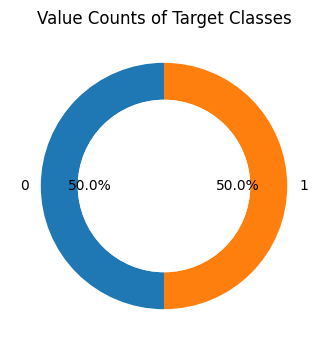

In [25]:
dist = df_resampled.target.value_counts()

plt.figure(figsize=(4, 4))
plt.pie(dist.values, labels=dist.index.astype(str), autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3))

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Value Counts of Target Classes')
plt.show()

In [26]:
df_resampled['target'].value_counts()

,count
target,
0,393
1,393


In [27]:
# Generate file paths based on ISIC_ids
dir_path = '/kaggle/input/isic-2024-challenge/train-image/image'
original_isic_ids = df_resampled['isic_id'].values
image_paths_train = [os.path.join(dir_path, f"{isic_id}.jpg") for isic_id in original_isic_ids]

# Check if image paths exist
class_image_paths = [path for path in image_paths_train if os.path.exists(path)]
print(len(class_image_paths))

786


In [28]:
save_dir = '/kaggle/working/augmented_images'
os.makedirs(save_dir, exist_ok=True)



# Define the target size for padding
target_size = (128, 128)
# Function to resize and pad an image to the target size using nearest pixel values
def resize_and_pad_image(image, target_size):
    h, w = image.shape[:2]
    # Calculate the resize ratio to maintain aspect ratio
    ratio = min(target_size[0] / h, target_size[1] / w)
    new_size = (int(w * ratio), int(h * ratio))

    # Resize the image
    resized_image = cv2.resize(image, new_size, interpolation=cv2.INTER_AREA)

    # Calculate padding to reach the target size
    pad_h = target_size[0] - resized_image.shape[0]
    pad_w = target_size[1] - resized_image.shape[1]
    top, bottom = pad_h // 2, pad_h - (pad_h // 2)
    left, right = pad_w // 2, pad_w - (pad_w // 2)

    # Pad image with nearest pixel values
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_REPLICATE)
    return padded_image

In [29]:
# # Create the ImageDataGenerator for augmentation
# datagen = ImageDataGenerator(
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# # Function to augment and save images 400273
# def augment_and_save_images(prepared_images, new_ids, save_dir, target_size=(128, 128, 3), num_new_images=143):
#     num_images = len(prepared_images)
#     new_rows = []

#     images_per_original = num_new_images // num_images

#     for idx, img in enumerate(prepared_images):
#         x = img_to_array(img)
#         x = x.reshape((1,) + x.shape)

#         i = 0
#         for batch in datagen.flow(x, batch_size=1):
#             if i >= images_per_original:
#                 break

#             new_image_name = f"{new_ids.pop(0)}.jpg"
#             new_image_path = os.path.join(save_dir, new_image_name)
#             save_img(new_image_path, batch[0])

#             new_rows.append({'isic_id': new_image_name.replace('.jpg', ''), 'image_path': new_image_path})

#             i += 1

#     return new_rows

# # Prepare stored images
# prepared_images = []
# for image_path in minority_class_image_paths:
#     img = cv2.imread(image_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     prepared_img = resize_and_pad_image(img, target_size)
#     save_img(os.path.join(save_dir, os.path.basename(image_path)), prepared_img)
#     prepared_images.append(prepared_img)

# # Generate new images for the minority class using prepared images
# new_data = augment_and_save_images(prepared_images, new_isic_ids, save_dir)

# # Convert the new data into a DataFrame
# df_new_images = pd.DataFrame(new_data)

# # Save the DataFrame to a CSV file
# df_new_images.to_csv('/kaggle/working/new_images_metadata.csv', index=False)

# print("Image augmentation and saving completed.")



# # Determine the majority class
# majority_class = y.value_counts().idxmax()
# print(f"Majority class: {majority_class}")

# # Get original isic_ids for the majority class
# original_isic_ids2 = df_train_processed[df_train_processed['target'] == majority_class]['isic_id'].values

# # Generate file paths based on ISIC_ids
# image_paths2 = [os.path.join(dir_path, f"{isic_id}.jpg") for isic_id in original_isic_ids2]

# # Check if image paths exist
# majority_class_image_paths = [path for path in image_paths2 if os.path.exists(path)]

# Resize, pad, and save the majority class images
# for image_path in class_image_paths:
#     img = cv2.imread(image_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     prepared_img = resize_and_pad_image(img, target_size)
#     save_img(os.path.join(save_dir, os.path.basename(image_path)), prepared_img)

# # Verify a few saved images
# saved_image_paths = [os.path.join(save_dir, f"{isic_id}.jpg") for isic_id in original_isic_ids2[:5]]
# for path in saved_image_paths:
#     img = cv2.imread(path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     plt.imshow(img)
#     plt.title(f"Saved Image: {os.path.basename(path)}")
#     plt.axis('off')
#     plt.show()


In [30]:
for image_path in class_image_paths:
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    prepared_img = resize_and_pad_image(img, target_size)
    save_img(os.path.join(save_dir, os.path.basename(image_path)), prepared_img)

In [31]:
# Define the output directory where images are stored
output_dir = '/kaggle/working/augmented_images'

# Get a list of all image file paths in the output directory
all_image_paths = [os.path.join(output_dir, fname) for fname in os.listdir(output_dir) if fname.endswith('.jpg')]


In [32]:
len(all_image_paths)

786

In [33]:
# for path in all_image_paths[:10]:
#     img = cv2.imread(path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     plt.imshow(img)
#     plt.title(f"Saved Image: {os.path.basename(path)}")
#     plt.axis('off')
#     plt.show()

In [34]:
# # Check if there are images in the directory
# import random
# if not all_image_paths:
#     print("No images found in the output directory.")
# else:
#     # Number of images to display
#     num_images_to_display = 5

#     # Randomly select image paths
#     selected_image_paths = random.sample(all_image_paths, min(num_images_to_display, len(all_image_paths)))

#     # Display each randomly selected image in full size
#     for image_path in selected_image_paths:
#         # Load the image
#         img = cv2.imread(image_path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#         # Get the shape of the image
#         shape = img.shape

#         # Display the image
#         plt.figure(figsize=(6, 6))
#         plt.imshow(img)
#         plt.title(f"{os.path.basename(image_path)} - Shape: {shape}")
#         plt.axis('off')
#         plt.show()

In [35]:
# Shuffle and split the data
df_shuffled = df_resampled.sample(frac=1, random_state=42).reset_index(drop=True)

train_df, temp_df = train_test_split(df_shuffled, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")


Training samples: 628
Validation samples: 79
Test samples: 79


In [36]:
def load_images(df, dir_path, target_size=(128, 128)):
    image_paths = [os.path.join(dir_path, f"{isic_id}.jpg") for isic_id in df['isic_id']]
    images = np.zeros((len(df), *target_size, 3), dtype=np.uint8)

    for idx, image_path in enumerate(image_paths):
        if os.path.exists(image_path):
            img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
            images[idx] = tf.keras.preprocessing.image.img_to_array(img)

    return images

In [37]:
output_dir = '/kaggle/working/augmented_images'

# Load images
train_images = load_images(train_df, output_dir)
val_images = load_images(val_df, output_dir)
test_images = load_images(test_df, output_dir)

# Extract tabular data
X_train_tab = train_df.drop(columns=['target', 'isic_id']).values
X_val_tab = val_df.drop(columns=['target', 'isic_id']).values
X_test_tab = test_df.drop(columns=['target', 'isic_id']).values

# Extract targets
y_train = train_df['target'].values
y_val = val_df['target'].values
y_test = test_df['target'].values

# Convert to tensors
train_images = tf.convert_to_tensor(train_images, dtype=tf.float32)
val_images = tf.convert_to_tensor(val_images, dtype=tf.float32)
test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)

X_train_tab = tf.convert_to_tensor(X_train_tab, dtype=tf.float32)
X_val_tab = tf.convert_to_tensor(X_val_tab, dtype=tf.float32)
X_test_tab = tf.convert_to_tensor(X_test_tab, dtype=tf.float32)

y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)


In [38]:
print("Training data shape:", X_train_tab.shape)


Training data shape: (628, 104)


In [39]:
def create_image_model(input_shape):
    inputs = Input(shape=input_shape)

    # Convolutional layers
    x = Conv2D(96, (11, 11), strides=4, activation='relu', padding='same')(inputs)
    x = MaxPooling2D((3, 3), strides=2)(x)
    x = Conv2D(256, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D((3, 3), strides=2)(x)
    x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((3, 3), strides=2)(x)

    # Flatten and dense layers
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)

    return Model(inputs, x, name="image_model")

In [40]:
def create_tabular_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(128, activation='relu')(inputs)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    return Model(inputs, x, name="tabular_model")

In [41]:
def create_combined_model(image_input_shape, tabular_input_shape):
    image_model = create_image_model(image_input_shape)
    tabular_model = create_tabular_model(tabular_input_shape)

    # Combine models
    combined = Concatenate()([image_model.output, tabular_model.output])
    x = Dense(512, activation='relu')(combined)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    return Model(inputs=[tabular_model.input, image_model.input], outputs=outputs)


In [42]:
# Define input shapes
tabular_input_shape = (104,)
image_input_shape = (128, 128, 3)

# Create and compile the model
model = create_combined_model(image_input_shape, tabular_input_shape)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 96)     │         34,944 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 15, 15, 96)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 15, 15, 256)    │        614,656 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 7, 7, 256)      │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 7, 7, 384)      │        885,120 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 7, 7, 384)      │      1,327,488 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 7, 7, 256)      │        884,992 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 3, 3, 256)      │              0 │ conv2d_4[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 104)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 2304)           │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         13,440 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 4096)           │      9,441,280 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 4096)           │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 64)             │          8,256 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 4096)           │     16,781,312 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)  

 Total params: 32,271,969 (123.11 MB)

 Trainable params: 32,271,969 (123.11 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)


In [ ]:
history = model.fit(
    [X_train_tab, train_images], y_train,
    validation_data=([X_val_tab, val_images], y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/100


In [ ]:
# Load the best model
model.load_weights('best_model.keras')

# Evaluate the model
test_loss, test_accuracy = model.evaluate([X_test_tab, test_images], y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Generate predictions
predictions = model.predict([X_test_tab, test_images])

# Convert probabilities to binary class labels (0 or 1)
class_predictions = (predictions > 0.5).astype(int).flatten()

# Assuming y_test contains the true labels for the test set
# Print the classification report
report = classification_report(y_test, class_predictions, target_names=['Benign_0', 'Malignant_1'])
print(report)

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()


In [ ]:
# Extract the tabular data (excluding 'isic_id' column)
X_test_tab_pred = df_test_processed.drop(columns=['isic_id']).values

# Convert tabular data to a Tensor
X_test_tab_tensor = tf.convert_to_tensor(X_test_tab_pred, dtype=tf.float32)

# Extract image IDs
image_ids = df_test_processed['isic_id'].values
image_ids

In [ ]:
X_test_tab_tensor

In [ ]:
def load_and_process_images(hdf5_file_path, image_ids, target_size=(128, 128)):
    images = {}

    with h5py.File(hdf5_file_path, 'r') as hdf5_file:
        for image_id in image_ids:
            # Check if image_id exists in the file
            if image_id in hdf5_file:
                # Load image data
                image_data = hdf5_file[image_id][()]

                # Decode image data
                image_data = cv2.imdecode(np.frombuffer(image_data, np.uint8), cv2.IMREAD_COLOR)

                # Resize and pad the image using OpenCV
                processed_image = resize_and_pad_image(image_data, target_size)

                images[image_id] = processed_image

    return images

# Define test image IDs
image_ids = ['ISIC_0015657', 'ISIC_0015729', 'ISIC_0015740']

# Load and process images
processed_images = load_and_process_images('/kaggle/input/isic-2024-challenge/test-image.hdf5', image_ids)

# Visualize the processed images
for image_id, image in processed_images.items():
    plt.figure()
    plt.title(f'Processed Image: {image_id}')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [ ]:
# Convert processed images to a tensor
def images_to_tensor(image_dict):
    image_list = [image for image in image_dict.values()]
    return tf.stack(image_list)

# Prepare image tensors
X_test_images_tensor = images_to_tensor(processed_images)

# Load the model and make predictions
model = tf.keras.models.load_model('best_model.keras')

In [ ]:
# Make predictions
predictions = model.predict([X_test_tab_tensor, X_test_images_tensor])

# Display predictions
print("Predictions:", predictions)

In [ ]:
from IPython.display import clear_output
!pip install tf_explain
clear_output()

In [ ]:
predictions_df = pd.DataFrame({'isic_id': image_ids, 'target': predictions.flatten()})
predictions_df

In [ ]:
predictions_df.to_csv("submission.csv", index = None)
